In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", None)
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from matplotlib.colors import ListedColormap
from matplotlib import cm

# Tableau 20 color palette for demonstration
colors = [(31, 119, 180), (255, 127, 14)]
# Conversion to [0.0 - 1.0] from [0.0 - 255.0]
colors = [(e[0] / 255.0, e[1] / 255.0, e[2] / 255.0) for e in colors]
cm = ListedColormap(colors)

In [2]:
#Load_dataset
part1 = pd.read_csv(r'data_for_meta/TRp1p4_TEp2_ar_fd__basic_agg.csv')
part3 = pd.read_csv(r'data_for_meta/TRp1p4_TEp3_ar_fd__basic_agg.csv')

p1_df_ = pd.DataFrame(part1, columns=['fd_prob','aggregated_prob', 'target'])
p3_df_ = pd.DataFrame(part3, columns=['fd_prob','aggregated_prob', 'target'])
tar = {0: 'NF', 1: 'FL'}
p1_df_['Target'] = p1_df_['target'].map(tar)
p3_df_['Target'] = p3_df_['target'].map(tar)
print(len(p1_df_), len(p3_df_))

p1_df = p1_df_.copy()
p3_df = p3_df_.copy()

1137 1029


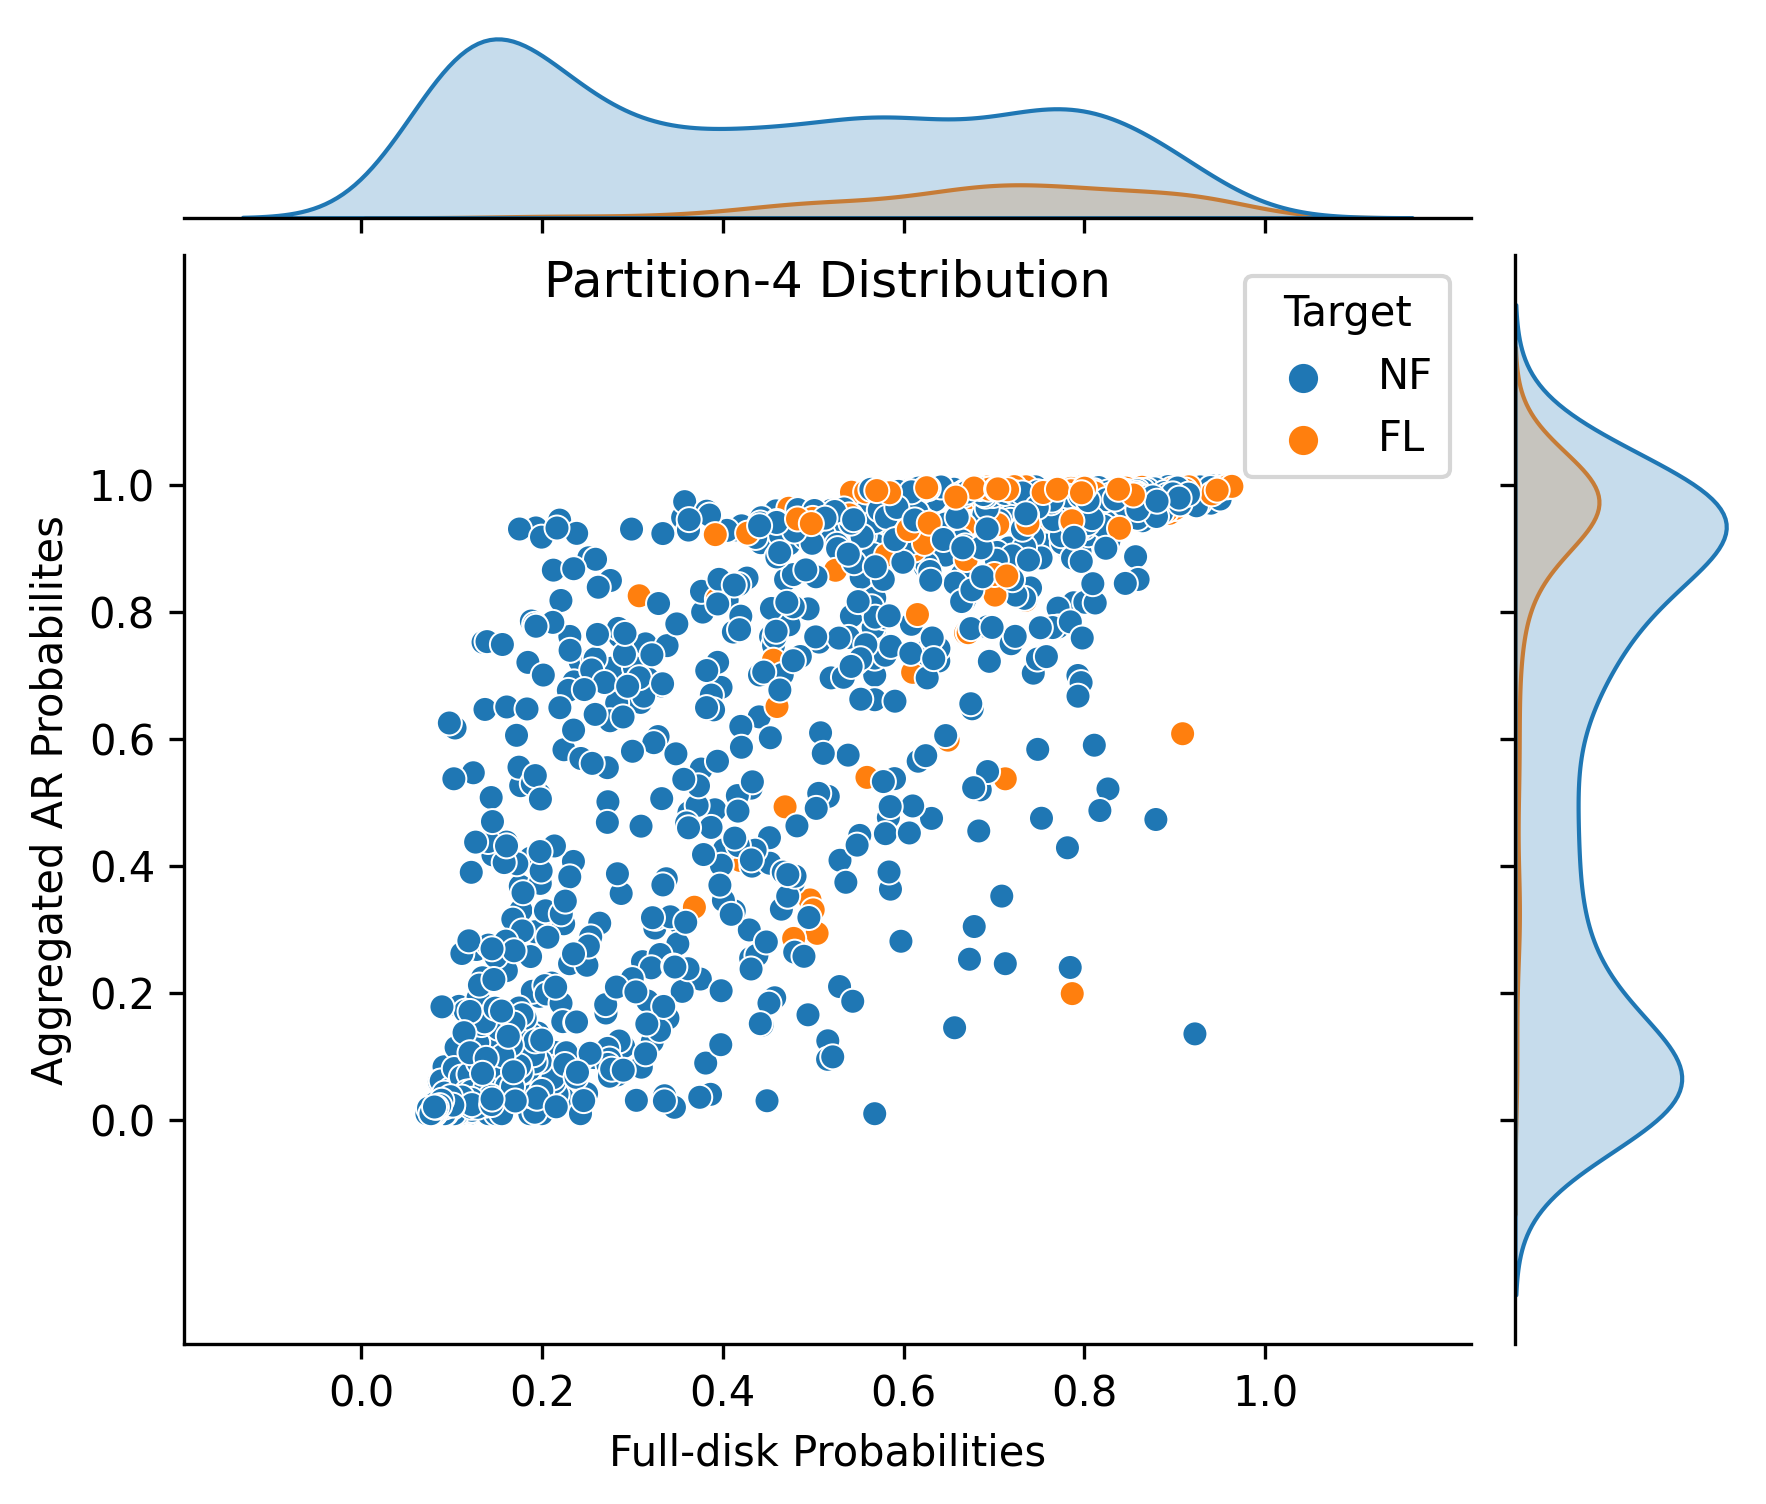

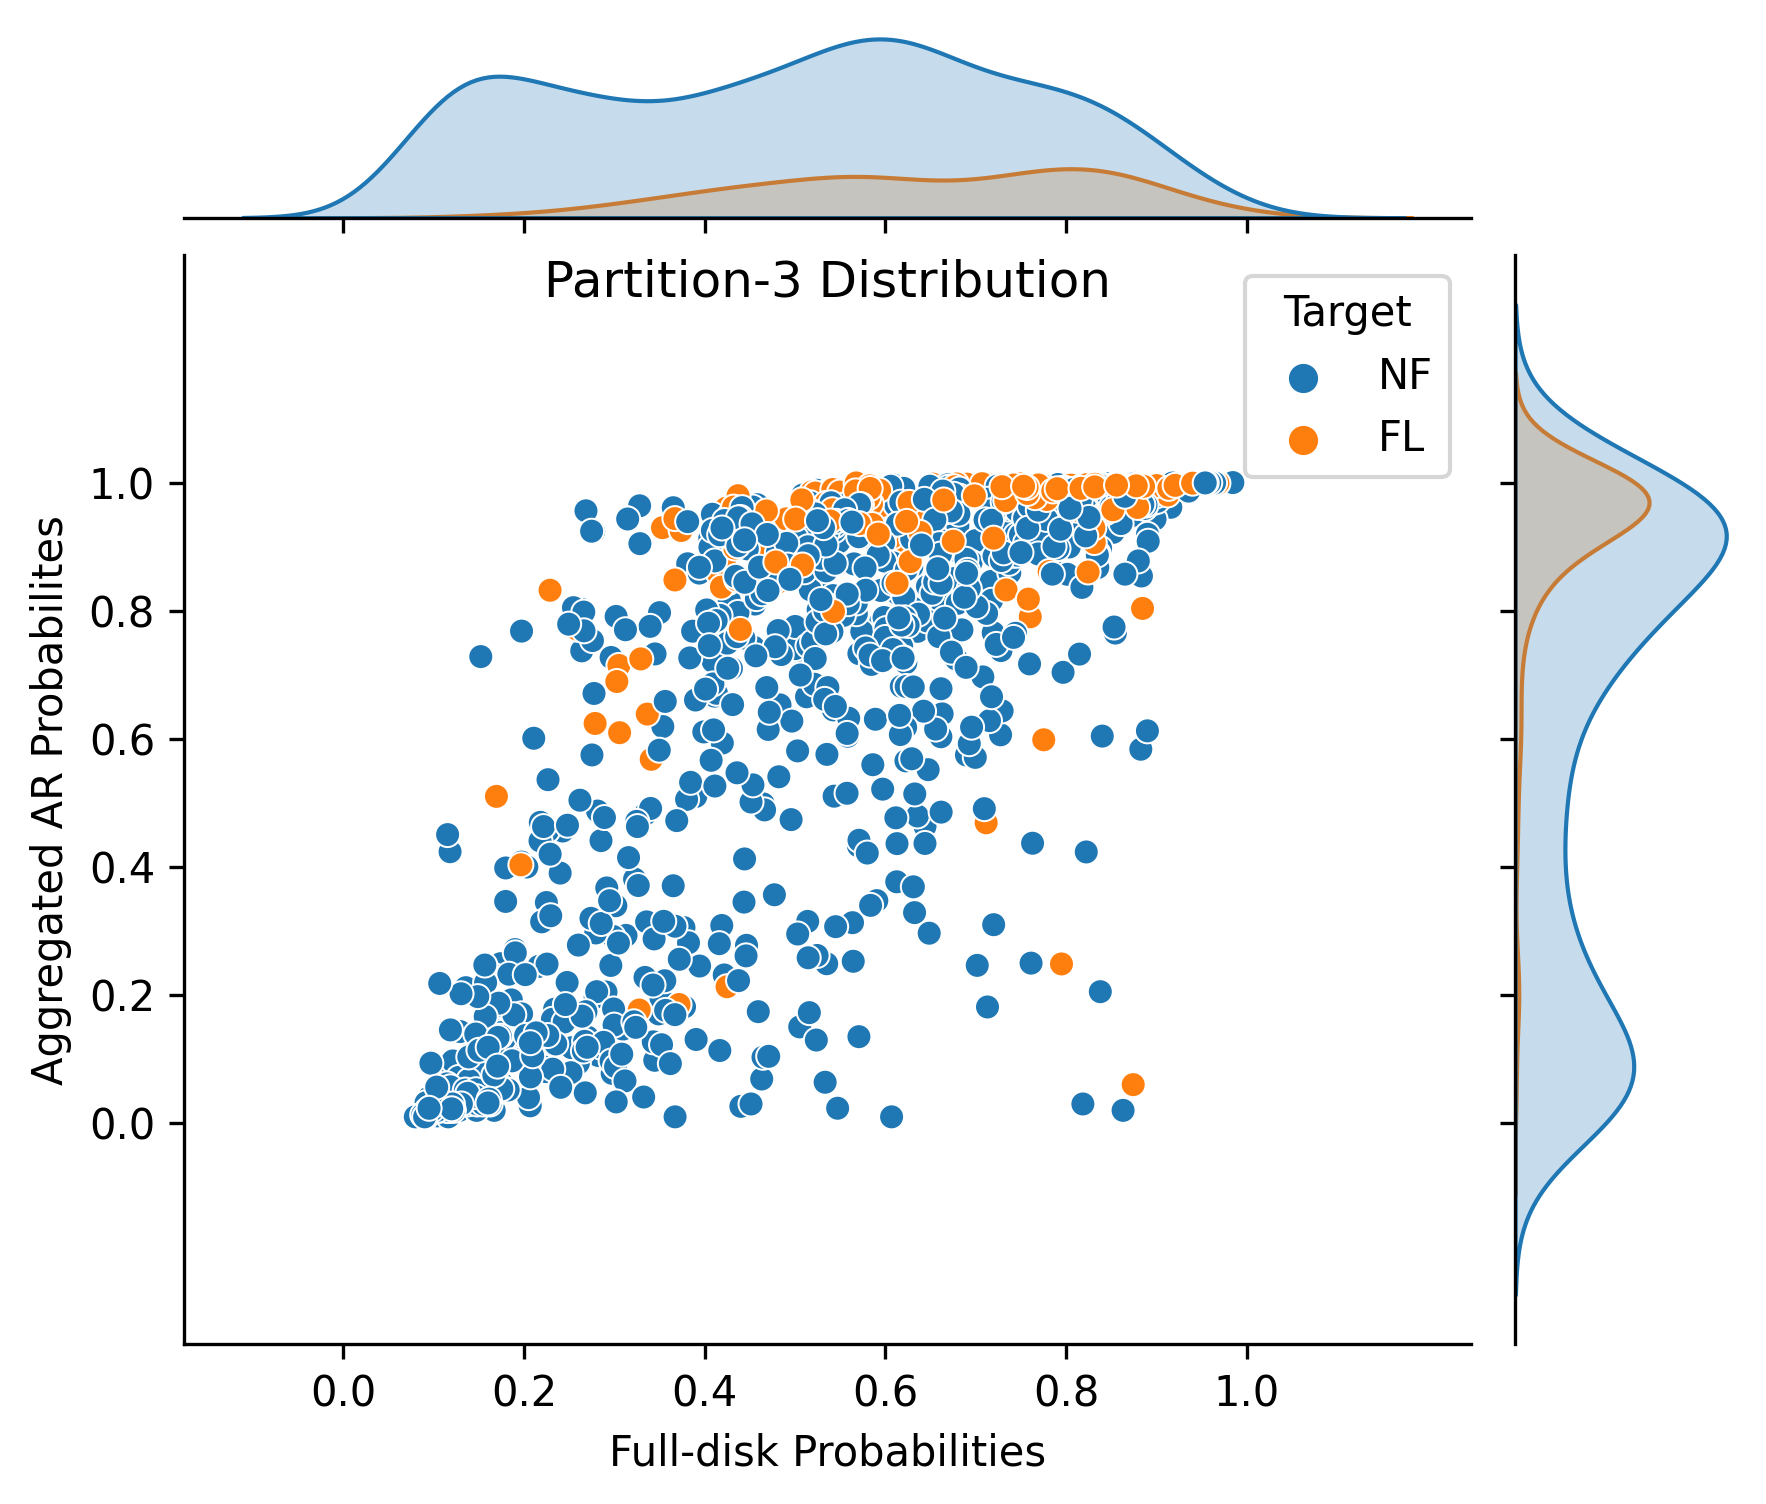

In [3]:
def visualize_data(data, title):
#     sns.scatterplot(x='fd_prob', y = 'aggregated_prob', data=data, hue='target')
    h = sns.jointplot(data=data, x="fd_prob", y="aggregated_prob", hue="Target", kind="scatter")
#     sns.rugplot(x='fd_prob', y = 'aggregated_prob', data=data, hue='target',height=.1)
    fig = plt.gcf()
    fig.set_size_inches(6, 5)
    fig.set_dpi(300)
    h.ax_joint.set_xlabel('Full-disk Probabilities')
    h.ax_joint.set_ylabel('Aggregated AR Probabilites')
    h.ax_joint.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    h.ax_joint.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    h.ax_joint.legend(title='Target')
    h.ax_joint.set_title(title, y=1.0, pad=-10)
    plt.show()
visualize_data(p1_df, 'Partition-4 Distribution')
visualize_data(p3_df, 'Partition-3 Distribution')

In [4]:
def accuracy_score(prediction, target):
    TN, FP, FN, TP = confusion_matrix(target, prediction).ravel()
    print("TP: ", TP, "FP: ", FP, "TN: ", TN, "FN: ", FN)
    #TSS Computation also known as "recall"
    tp_rate = TP / float(TP + FN) if TP > 0 else 0  
    fp_rate = FP / float(FP + TN) if FP > 0 else 0
    TSS = tp_rate - fp_rate
    
    #HSS2 Computation
    N = TN + FP
    P = TP + FN
    HSS = (2 * (TP * TN - FN * FP)) / float((P * (FN + TN) + (TP + FP) * N))

    return TSS, HSS

def tss_score(prediction, target):
    TN, FP, FN, TP = confusion_matrix(target, prediction).ravel()
    tp_rate = TP / float(TP + FN) if TP > 0 else 0  
    fp_rate = FP / float(FP + TN) if FP > 0 else 0
    TSS = tp_rate - fp_rate
    return TSS

def threshold(df):
    y_pred = df.to_numpy().reshape(len(df),)
    yp = np.where(y_pred >= 0.5, 1, 0)
    return yp

def accuracy_score_with_conf_mat(prediction, target):
    TN, FP, FN, TP = confusion_matrix(target, prediction).ravel()
#     print("TP: ", TP, "FP: ", FP, "TN: ", TN, "FN: ", FN)
    #TSS Computation also known as "recall"
    tp_rate = TP / float(TP + FN) if TP > 0 else 0  
    fp_rate = FP / float(FP + TN) if FP > 0 else 0
    TSS = tp_rate - fp_rate
    
    #HSS2 Computation
    N = TN + FP
    P = TP + FN
    HSS = (2 * (TP * TN - FN * FP)) / float((P * (FN + TN) + (TP + FP) * N))

    return TSS, HSS, TN, FP, FN, TP

tss = make_scorer(tss_score)

In [5]:
#Compute TSS and HSS for full-disk
fd_p1_pred = threshold(p1_df_['fd_prob'])
fd_p3_pred = threshold(p3_df_['fd_prob'])
TSS, HSS = accuracy_score(fd_p1_pred, p1_df_['target'].to_numpy().reshape(len(p1_df_['target']),))
print('Full-disk Partition 4: TSS: {:.4f} | HSS: {:.4f}'.format(TSS, HSS))
TSS, HSS = accuracy_score(fd_p3_pred, p3_df_['target'].to_numpy().reshape(len(p3_df_['target']),))
print('Full-disk Partition 3: TSS: {:.4f} | HSS: {:.4f}\n'.format(TSS, HSS))


#Compute TSS and HSS for Active-Region
ar_p1_pred = threshold(p1_df_['aggregated_prob'])
ar_p3_pred = threshold(p3_df_['aggregated_prob'])
TSS, HSS = accuracy_score(ar_p1_pred, p1_df_['target'].to_numpy().reshape(len(p1_df_['target']),))
print('Aggregated Partition 4: TSS: {:.4f} | HSS: {:.4f}'.format(TSS, HSS))
TSS, HSS = accuracy_score(ar_p3_pred, p3_df_['target'].to_numpy().reshape(len(p3_df_['target']),))
print('Aggregated Partition 3: TSS: {:.4f} | HSS: {:.4f}\n'.format(TSS, HSS))

#Baseline Metamodel
p1_df_['baseline'] = (p1_df_['fd_prob'] + p1_df_['aggregated_prob'])/2
p3_df_['baseline'] = (p3_df_['fd_prob'] + p3_df_['aggregated_prob'])/2
p1_weighted_pred = threshold(p1_df_['baseline'])
p3_weighted_pred = threshold(p3_df_['baseline'])

TSS, HSS = accuracy_score(p1_weighted_pred, p1_df_['target'].to_numpy().reshape(len(p1_df_['target']),))
print('Partition 4 Baseline Meta: TSS: {:.4f} | HSS: {:.4f}'.format(TSS, HSS))
TSS, HSS = accuracy_score(p3_weighted_pred, p3_df_['target'].to_numpy().reshape(len(p3_df_['target']),))
print('Partition 3 Baseline Meta: TSS: {:.4f} | HSS: {:.4f}'.format(TSS, HSS))

TP:  120 FP:  425 TN:  573 FN:  19
Full-disk Partition 4: TSS: 0.4375 | HSS: 0.1938
TP:  138 FP:  455 TN:  395 FN:  41
Full-disk Partition 3: TSS: 0.2357 | HSS: 0.1232

TP:  129 FP:  552 TN:  446 FN:  10
Aggregated Partition 4: TSS: 0.3750 | HSS: 0.1400
TP:  172 FP:  532 TN:  318 FN:  7
Aggregated Partition 3: TSS: 0.3350 | HSS: 0.1553

TP:  129 FP:  504 TN:  494 FN:  10
Partition 4 Baseline Meta: TSS: 0.4230 | HSS: 0.1672
TP:  168 FP:  531 TN:  319 FN:  11
Partition 3 Baseline Meta: TSS: 0.3138 | HSS: 0.1462


In [6]:
penalty = ['l1', 'l2', 'elasticnet']
alpha = np.arange(1e-4, 1.1, 1e-4)
print(alpha.shape)
X_tr, X_te, y_tr, y_te = p1_df[['fd_prob', 'aggregated_prob']].values, p3_df[['fd_prob', 'aggregated_prob']].values, p1_df['target'], p3_df['target']

(10999,)


In [7]:
def sgd(penalty, alpha, X_train, X_test, y_train, y_test):
    clf_=None
    clf= SGDClassifier(alpha=alpha,eta0=0.00001,
                       loss='log',
                       penalty=penalty,
                       class_weight='balanced', max_iter=5000000,
                       learning_rate = 'optimal', random_state=14)
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    TSS, HSS, TN, FP, FN, TP = accuracy_score_with_conf_mat(y_pred, y_test)
    return TSS, HSS, clf, TN, FP, FN, TP

In [8]:
def hyperparameter_tuning(X_tr, X_te, y_tr, y_te, best):
    for p in penalty:
        for a in alpha:
            tss, hss, clf, TN, FP, FN, TP = sgd(p, a, X_tr, X_te, y_tr, y_te)
            if (tss>=best['tss'] and hss>=best['hss']):
                best['tss'] = tss
                best['hss'] = hss
                best['model'] = clf
                best['penalty'] = p
                best['conf_mat'] = [TN, FP, FN, TP]
                print(best)
    return best

In [9]:
#Fold1
fold_1_best = dict()
fold_1_best['tss'] = 0
fold_1_best['hss'] = 0
best_fold1 = hyperparameter_tuning(X_tr, X_te, y_tr, y_te, fold_1_best)

{'tss': 0.3409792967466316, 'hss': 0.22925776252731495, 'model': SGDClassifier(class_weight='balanced', eta0=1e-05, loss='log', max_iter=5000000,
              penalty='l1', random_state=14), 'penalty': 'l1', 'conf_mat': [570, 280, 59, 120]}
{'tss': 0.3821229050279329, 'hss': 0.22967936144871026, 'model': SGDClassifier(alpha=0.006900000000000001, class_weight='balanced', eta0=1e-05,
              loss='log', max_iter=5000000, penalty='l1', random_state=14), 'penalty': 'l1', 'conf_mat': [510, 340, 39, 140]}
{'tss': 0.38418008544199805, 'hss': 0.2296981069053256, 'model': SGDClassifier(alpha=0.007200000000000001, class_weight='balanced', eta0=1e-05,
              loss='log', max_iter=5000000, penalty='l1', random_state=14), 'penalty': 'l1', 'conf_mat': [507, 343, 38, 141]}
{'tss': 0.38976667762076905, 'hss': 0.23273145404669307, 'model': SGDClassifier(alpha=0.007300000000000001, class_weight='balanced', eta0=1e-05,
              loss='log', max_iter=5000000, penalty='l1', random_state=14

In [10]:
fold_2_best = dict()
fold_2_best['tss'] = 0
fold_2_best['hss'] = 0
best_fold2 = hyperparameter_tuning(X_te, X_tr, y_te, y_tr, fold_2_best)

{'tss': 0.45212727613500386, 'hss': 0.20921695417875175, 'model': SGDClassifier(class_weight='balanced', eta0=1e-05, loss='log', max_iter=5000000,
              penalty='l1', random_state=14), 'penalty': 'l1', 'conf_mat': [602, 396, 21, 118]}
{'tss': 0.4917677080780265, 'hss': 0.2678542681801584, 'model': SGDClassifier(alpha=0.0004, class_weight='balanced', eta0=1e-05, loss='log',
              max_iter=5000000, penalty='l1', random_state=14), 'penalty': 'l1', 'conf_mat': [699, 299, 29, 110]}
{'tss': 0.49276971208604253, 'hss': 0.26885342615262087, 'model': SGDClassifier(alpha=0.0004, class_weight='balanced', eta0=1e-05, loss='log',
              max_iter=5000000, random_state=14), 'penalty': 'l2', 'conf_mat': [700, 298, 29, 110]}
{'tss': 0.5085206383991003, 'hss': 0.26970205575032785, 'model': SGDClassifier(alpha=0.4257, class_weight='balanced', eta0=1e-05, loss='log',
              max_iter=5000000, random_state=14), 'penalty': 'l2', 'conf_mat': [687, 311, 25, 114]}
{'tss': 0.5085206

{'tss': 0.5145326624471966, 'hss': 0.27560602667366846, 'model': SGDClassifier(alpha=0.43170000000000003, class_weight='balanced', eta0=1e-05,
              loss='log', max_iter=5000000, random_state=14), 'penalty': 'l2', 'conf_mat': [693, 305, 25, 114]}
{'tss': 0.5145326624471966, 'hss': 0.27560602667366846, 'model': SGDClassifier(alpha=0.4318, class_weight='balanced', eta0=1e-05, loss='log',
              max_iter=5000000, random_state=14), 'penalty': 'l2', 'conf_mat': [693, 305, 25, 114]}
{'tss': 0.5145326624471966, 'hss': 0.27560602667366846, 'model': SGDClassifier(alpha=0.4319, class_weight='balanced', eta0=1e-05, loss='log',
              max_iter=5000000, random_state=14), 'penalty': 'l2', 'conf_mat': [693, 305, 25, 114]}
{'tss': 0.5145326624471966, 'hss': 0.27560602667366846, 'model': SGDClassifier(alpha=0.432, class_weight='balanced', eta0=1e-05, loss='log',
              max_iter=5000000, random_state=14), 'penalty': 'l2', 'conf_mat': [693, 305, 25, 114]}
{'tss': 0.5145326624

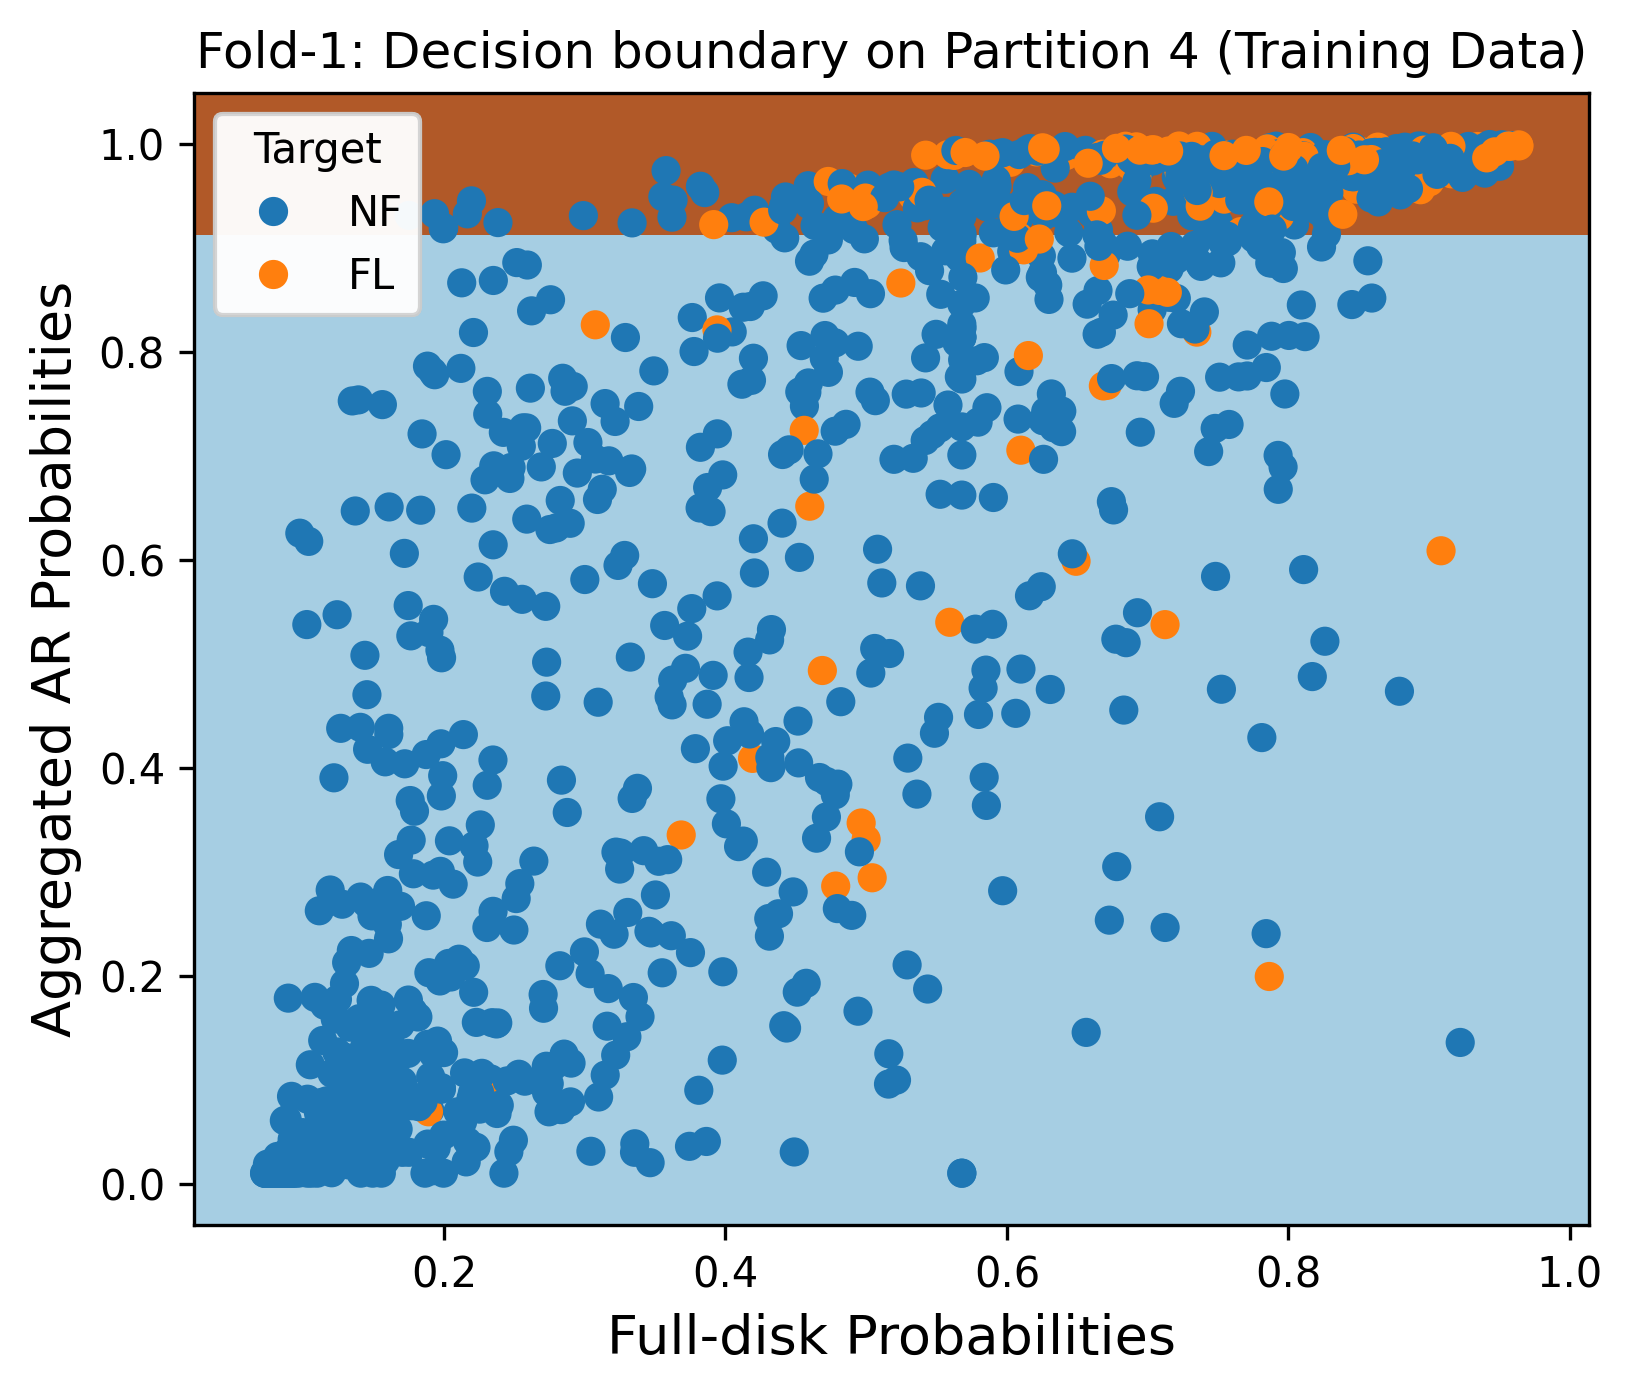

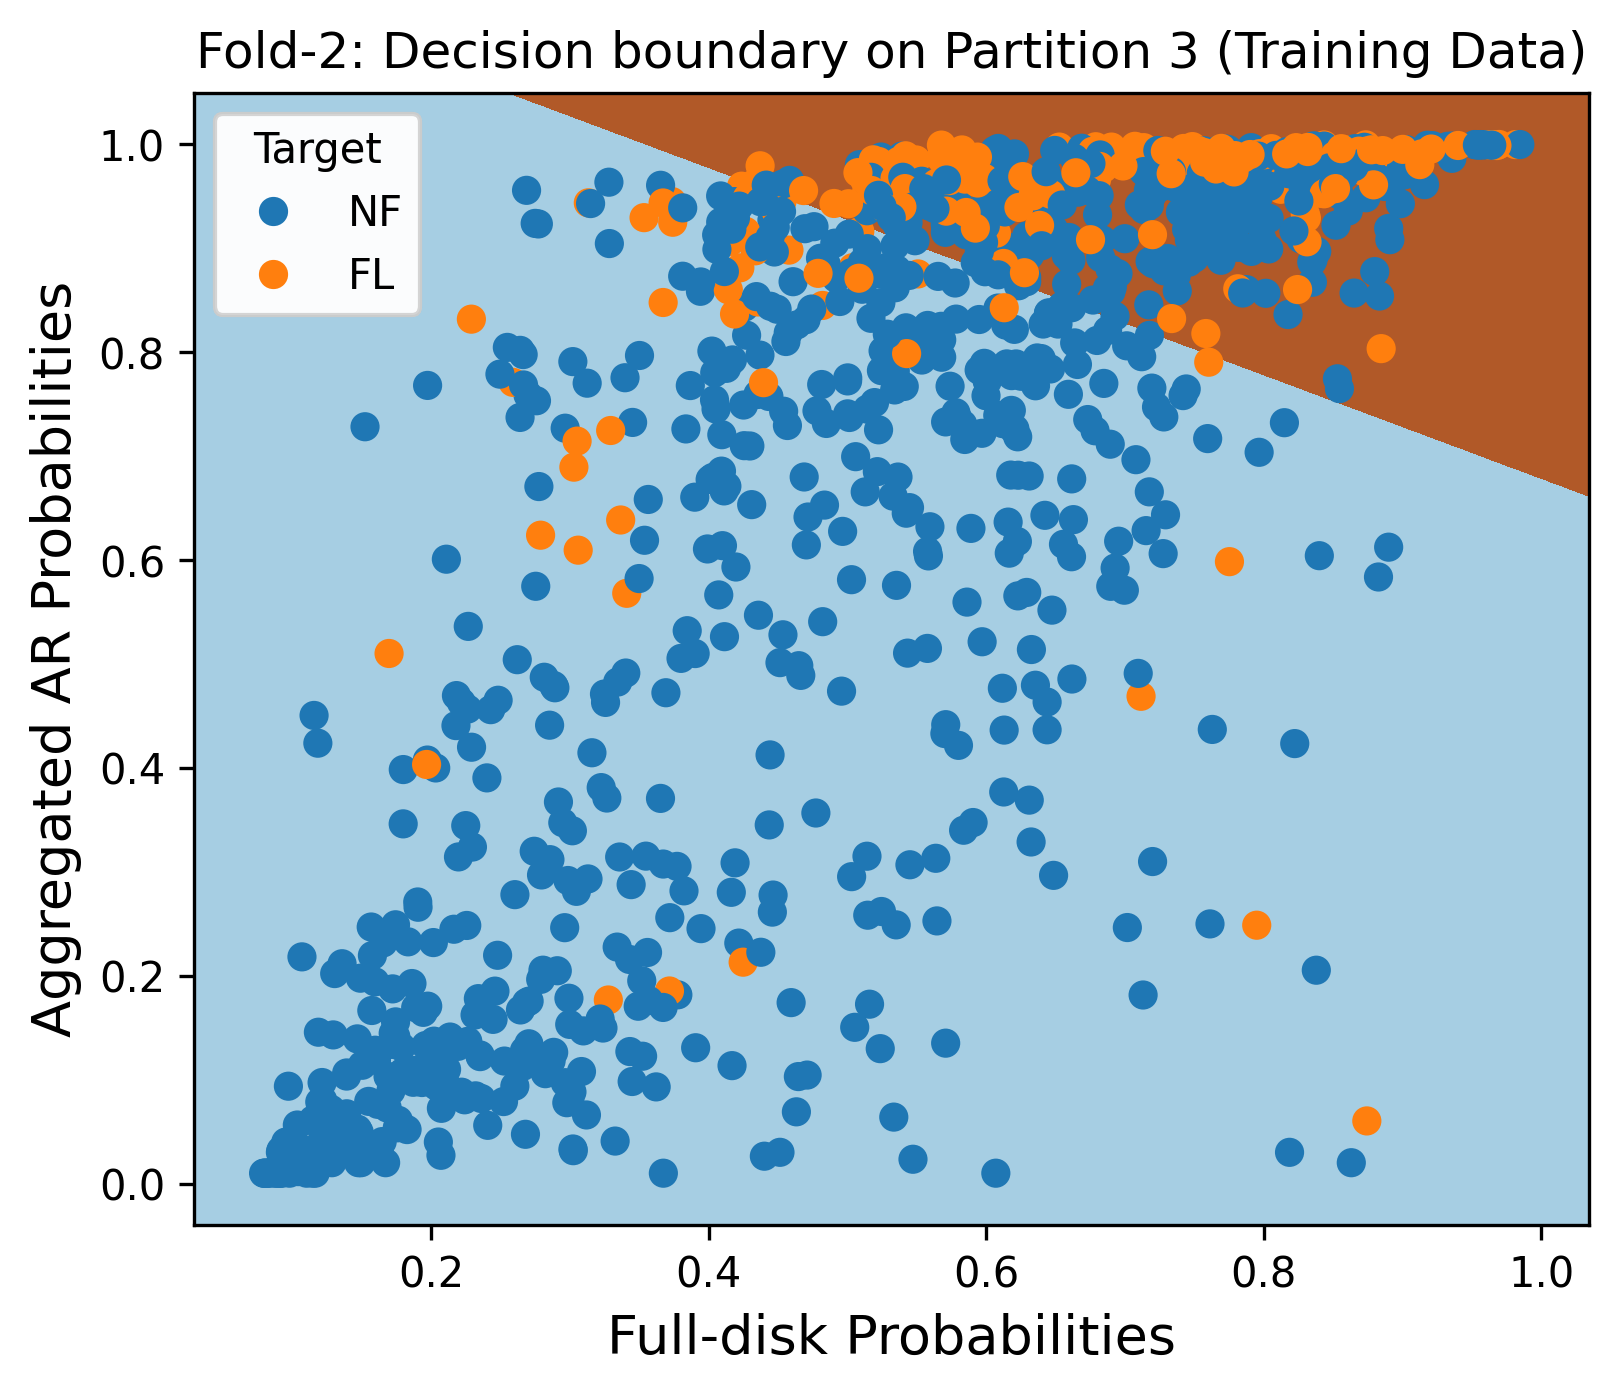

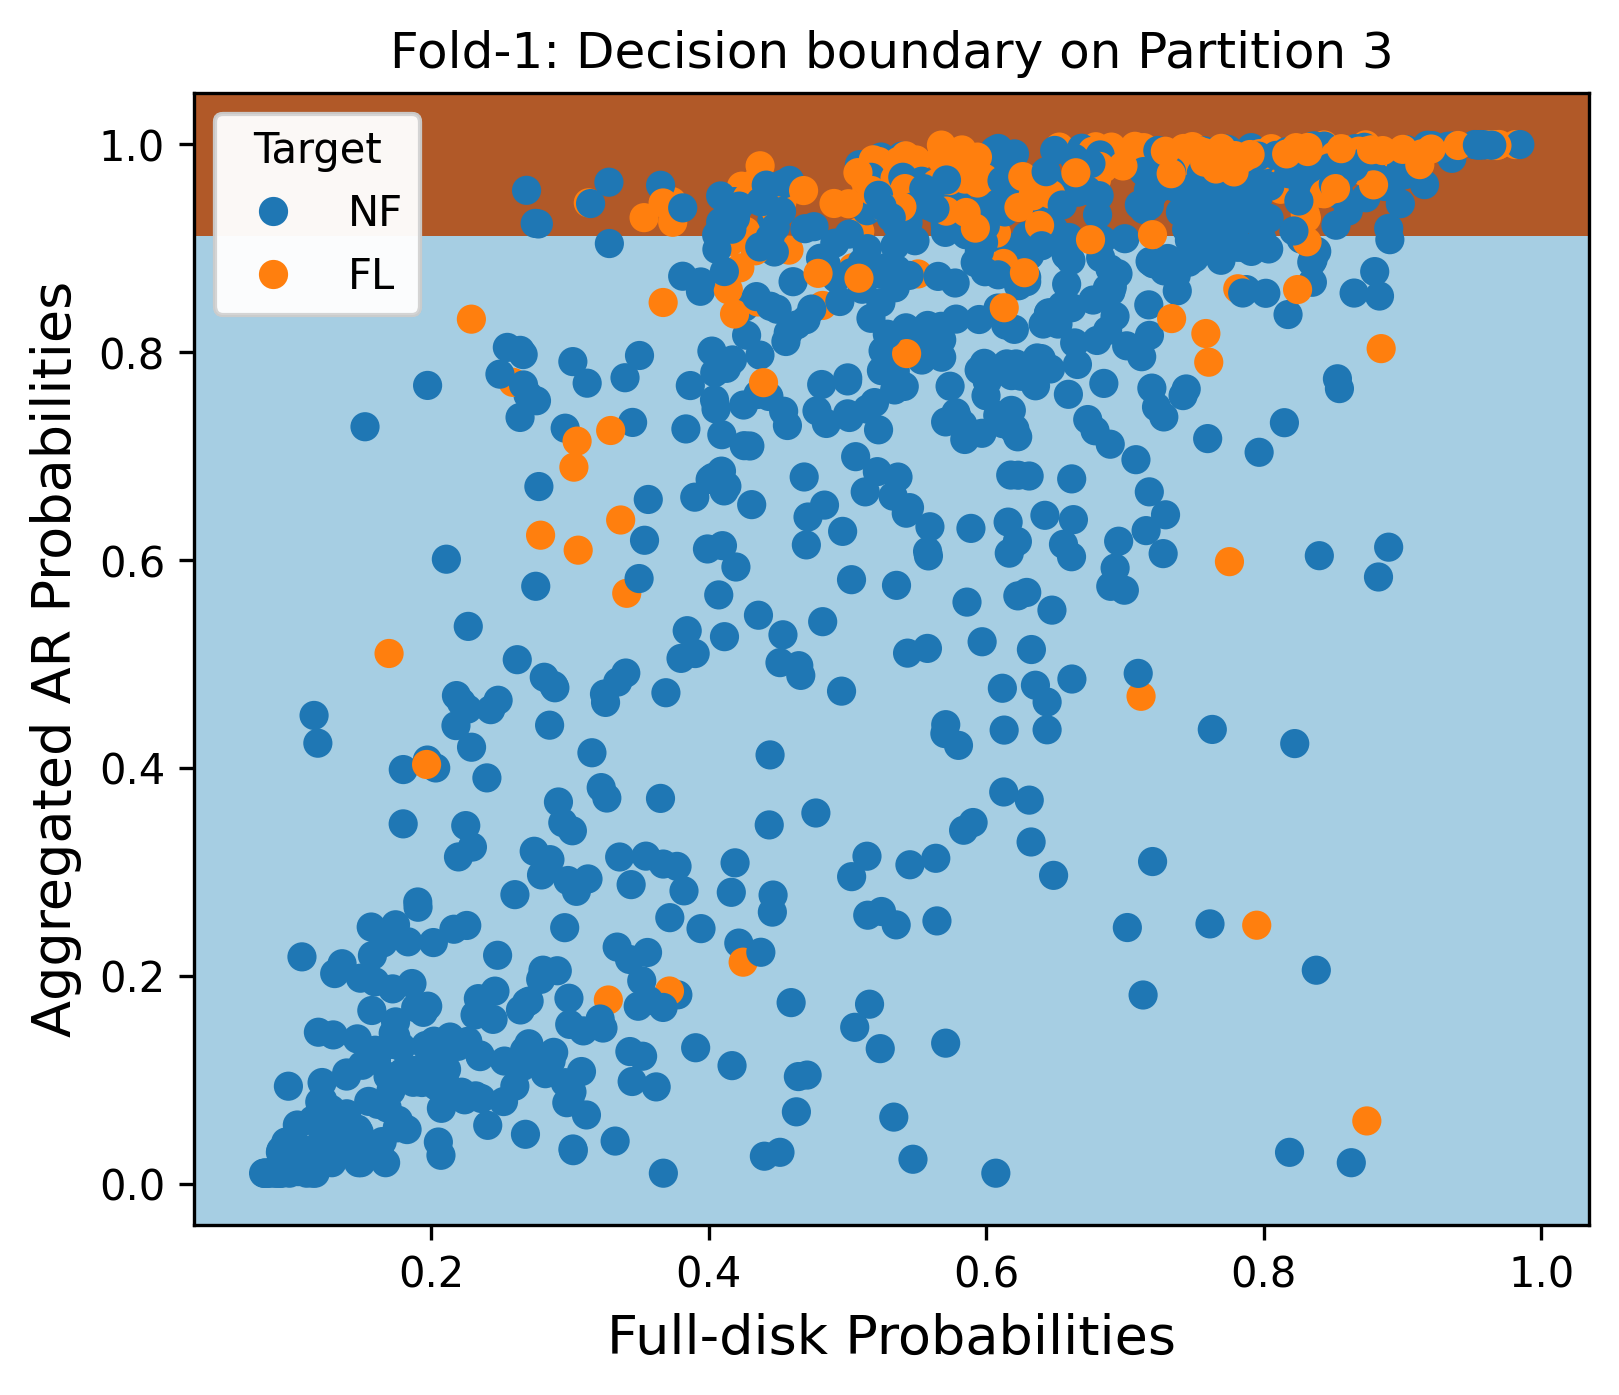

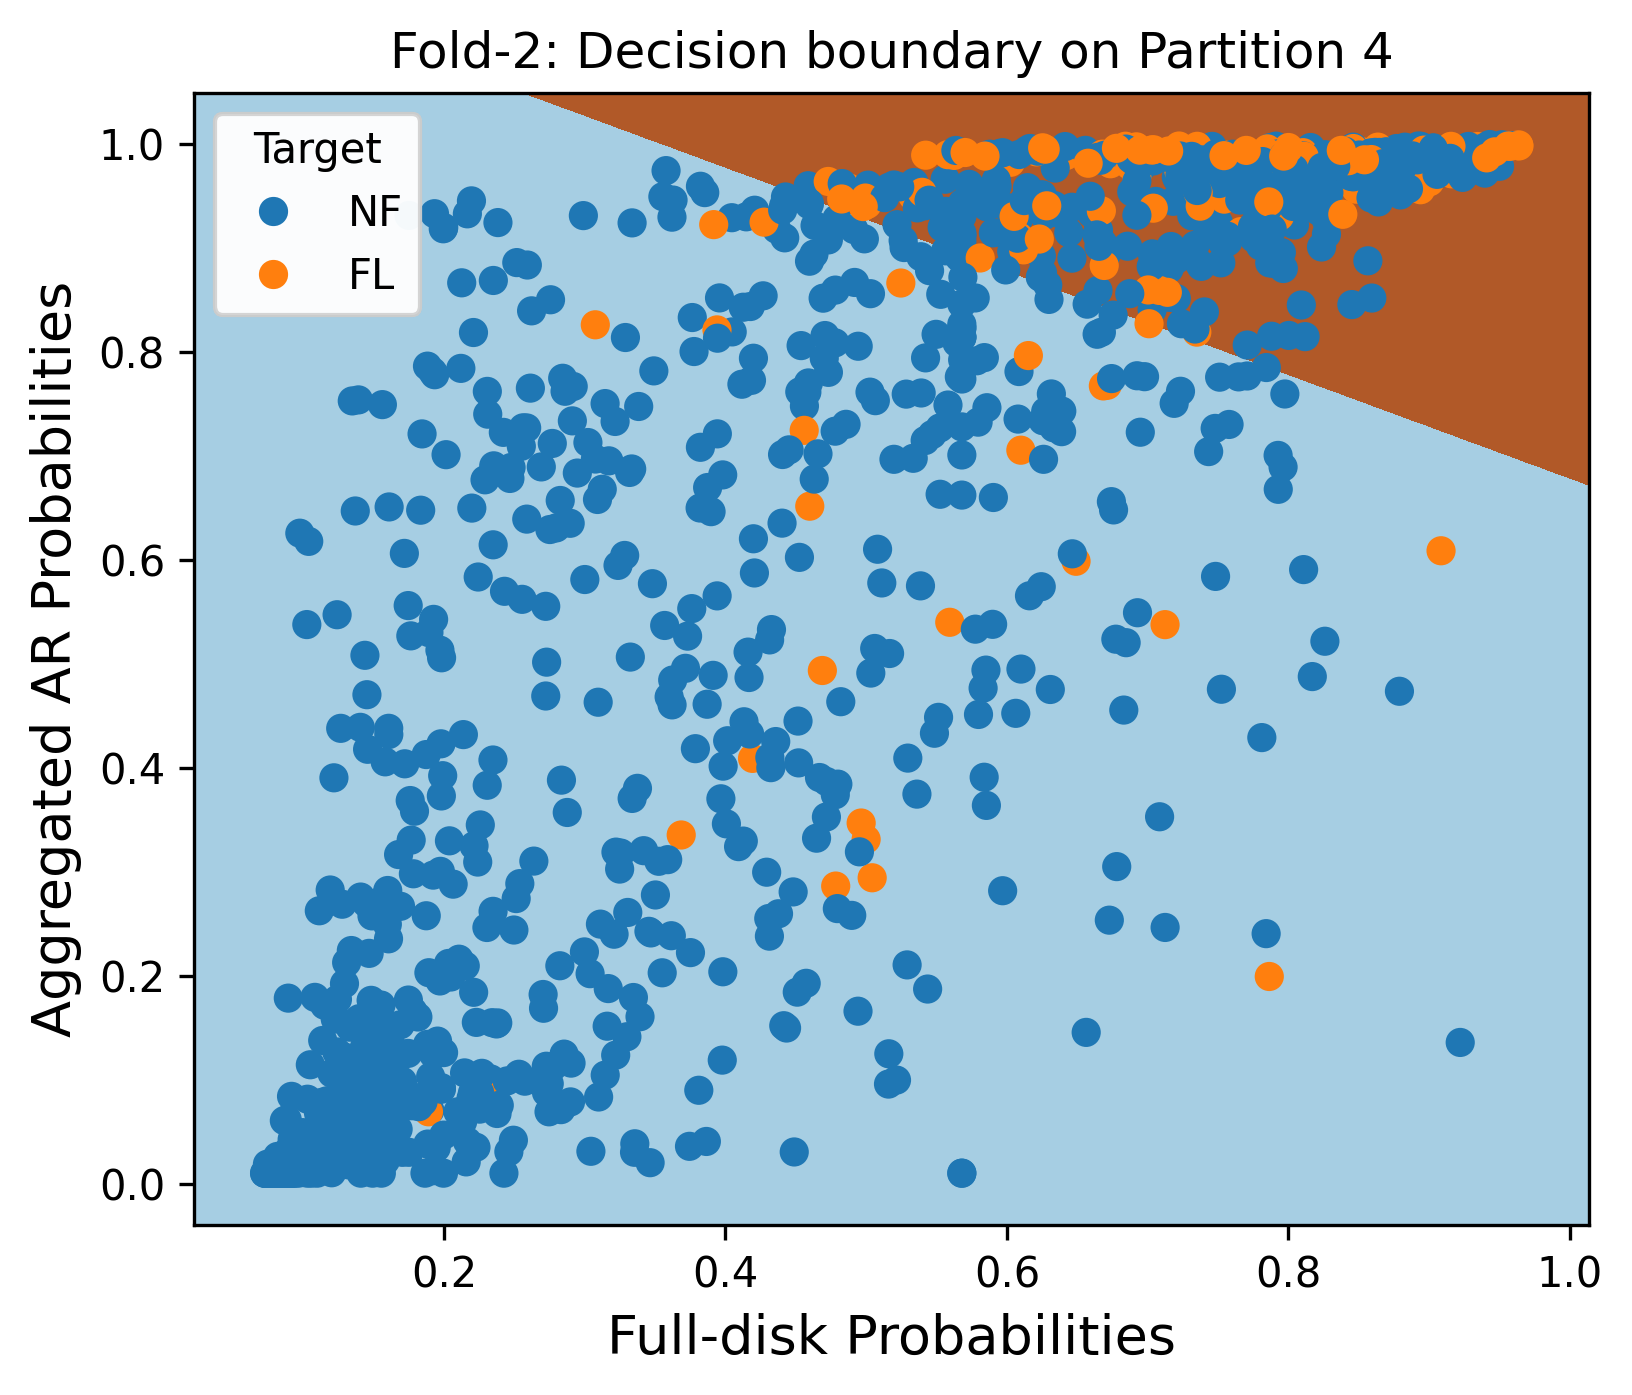

In [11]:
def visualize_decision_boundary(X, Y, model, title):
    x_min, x_max = X[:, 0].min() - .05, X[:, 0].max() + .05
    y_min, y_max = X[:, 1].min() - .05, X[:, 1].max() + .05
    h = .0002  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots(figsize=(6,5))
    fig.set_dpi(300)

#     plt.figure(1, figsize=(6, 6))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired, shading='nearest')

    # Plot also the training points
    s = ax.scatter(X[:, 0], X[:, 1], c=Y,cmap=cm)
    plt.xlabel('Full-disk Probabilities', fontsize=13)
    plt.ylabel('Aggregated AR Probabilities', fontsize=13)
    plt.title(title)
    legend1 = ax.legend(*s.legend_elements(),
                    loc="upper left", title='Target')
    legend1.get_texts()[0].set_text('NF')
    legend1.get_texts()[1].set_text('FL')
    ax.add_artist(legend1)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()
visualize_decision_boundary(p1_df[['fd_prob', 'aggregated_prob']].values, p1_df['target'], best_fold1['model'], 'Fold-1: Decision boundary on Partition 4 (Training Data)')
visualize_decision_boundary(p3_df[['fd_prob', 'aggregated_prob']].values, p3_df['target'], best_fold2['model'], 'Fold-2: Decision boundary on Partition 3 (Training Data)' )
visualize_decision_boundary(p3_df[['fd_prob', 'aggregated_prob']].values, p3_df['target'], best_fold1['model'], 'Fold-1: Decision boundary on Partition 3')
visualize_decision_boundary(p1_df[['fd_prob', 'aggregated_prob']].values, p1_df['target'], best_fold2['model'], 'Fold-2: Decision boundary on Partition 4')

In [12]:
print('Best Validation Fold-1')
print(best_fold1)
print('Best Validation Fold-2')
print(best_fold2)

Best Validation Fold-1
{'tss': 0.4747814656588893, 'hss': 0.33880991130851595, 'model': SGDClassifier(alpha=0.0834, class_weight='balanced', eta0=1e-05, loss='log',
              max_iter=5000000, penalty='l1', random_state=14), 'penalty': 'l1', 'conf_mat': [622, 228, 46, 133]}
Best Validation Fold-2
{'tss': 0.5155346664552125, 'hss': 0.27660146391932006, 'model': SGDClassifier(alpha=0.43320000000000003, class_weight='balanced', eta0=1e-05,
              loss='log', max_iter=5000000, random_state=14), 'penalty': 'l2', 'conf_mat': [694, 304, 25, 114]}


In [13]:
#Compute TSS and HSS for full-disk
fd_p1_pred = threshold(p1_df_['fd_prob'])
fd_p3_pred = threshold(p3_df_['fd_prob'])
TSS, HSS = accuracy_score(fd_p1_pred, p1_df_['target'].to_numpy().reshape(len(p1_df_['target']),))
print('Full-disk Partition 4: TSS: {:.4f} | HSS: {:.4f}'.format(TSS, HSS))
TSS, HSS = accuracy_score(fd_p3_pred, p3_df_['target'].to_numpy().reshape(len(p3_df_['target']),))
print('Full-disk Partition 3: TSS: {:.4f} | HSS: {:.4f}\n'.format(TSS, HSS))


#Compute TSS and HSS for Active-Region
ar_p1_pred = threshold(p1_df_['aggregated_prob'])
ar_p3_pred = threshold(p3_df_['aggregated_prob'])
TSS, HSS = accuracy_score(ar_p1_pred, p1_df_['target'].to_numpy().reshape(len(p1_df_['target']),))
print('Aggregated Partition 4: TSS: {:.4f} | HSS: {:.4f}'.format(TSS, HSS))
TSS, HSS = accuracy_score(ar_p3_pred, p3_df_['target'].to_numpy().reshape(len(p3_df_['target']),))
print('Aggregated Partition 3: TSS: {:.4f} | HSS: {:.4f}\n'.format(TSS, HSS))

#Baseline Metamodel
p1_df_['baseline'] = (p1_df_['fd_prob'] + p1_df_['aggregated_prob'])/2
p3_df_['baseline'] = (p3_df_['fd_prob'] + p3_df_['aggregated_prob'])/2
p1_weighted_pred = threshold(p1_df_['baseline'])
p3_weighted_pred = threshold(p3_df_['baseline'])

TSS, HSS = accuracy_score(p1_weighted_pred, p1_df_['target'].to_numpy().reshape(len(p1_df_['target']),))
print('Partition 4 Baseline Meta: TSS: {:.4f} | HSS: {:.4f}'.format(TSS, HSS))
TSS, HSS = accuracy_score(p3_weighted_pred, p3_df_['target'].to_numpy().reshape(len(p3_df_['target']),))
print('Partition 3 Baseline Meta: TSS: {:.4f} | HSS: {:.4f}'.format(TSS, HSS))

TP:  120 FP:  425 TN:  573 FN:  19
Full-disk Partition 4: TSS: 0.4375 | HSS: 0.1938
TP:  138 FP:  455 TN:  395 FN:  41
Full-disk Partition 3: TSS: 0.2357 | HSS: 0.1232

TP:  129 FP:  552 TN:  446 FN:  10
Aggregated Partition 4: TSS: 0.3750 | HSS: 0.1400
TP:  172 FP:  532 TN:  318 FN:  7
Aggregated Partition 3: TSS: 0.3350 | HSS: 0.1553

TP:  129 FP:  504 TN:  494 FN:  10
Partition 4 Baseline Meta: TSS: 0.4230 | HSS: 0.1672
TP:  168 FP:  531 TN:  319 FN:  11
Partition 3 Baseline Meta: TSS: 0.3138 | HSS: 0.1462
